<a href="https://colab.research.google.com/github/7kylor/AIDL-Module-Assignment/blob/main/ships_airplanes_classification_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#My dataset is available in googledrive; so I am accessing my drive from colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#Once this is executed, you will see your drive appearing on the left hand side

Mounted at /content/drive


In [ ]:
# Define paths to the dataset
train_dir = '/content/drive/MyDrive/AI/Train'  # Update with your actual path
test_dir = '/content/drive/MyDrive/AI/Test'    # Update with your actual path

In [ ]:
import os
print(len(os.listdir('/content/drive/MyDrive/AI/Train/airplane')))
print(len(os.listdir('/content/drive/MyDrive/AI/Train/ship')))
print(len(os.listdir('/content/drive/MyDrive/AI/Test/airplane')))
print(len(os.listdir('/content/drive/MyDrive/AI/Test/ship')))

5040
5010
1020
1000


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of the images for validation
)

# Load and prepare training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification (cats vs. dogs)
    subset='training'  # Specify 'training' for the training set
)

# Create ImageDataGenerator for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Note: Using the same validation split as in the training set
)

# Load and prepare validation data
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 8040 images belonging to 2 classes.
Found 2010 images belonging to 2 classes.


In [ ]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

resnet_model = Sequential()    #ResNet50 is a pre-trained model
pretrained_model = tf.keras.applications.ResNet50(include_top = False, #because i have my own image of a diff dimension
                                                input_shape = (256,256,3),
                                                pooling = 'max', classes = 2,
                                                weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False  #all layers in the Resnet50 is not trainable; keep those weights; I am going to add my own i/p and other layers

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(1, activation = 'sigmoid'))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
from keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #binary_crossentropy - binary classification

In [8]:
history = resnet_model.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
252/252 [==============================] - 7630s 30s/step - loss: 0.9178 - accuracy: 0.5486 - val_loss: 0.7084 - val_accuracy: 0.5398
Epoch 2/3
252/252 [==============================] - 29s 114ms/step - loss: 0.6549 - accuracy: 0.6376 - val_loss: 0.6334 - val_accuracy: 0.6204
Epoch 3/3
252/252 [==============================] - 28s 111ms/step - loss: 0.6194 - accuracy: 0.6563 - val_loss: 0.6457 - val_accuracy: 0.6144


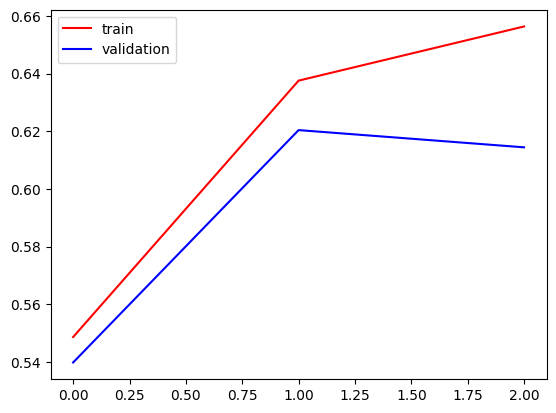

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

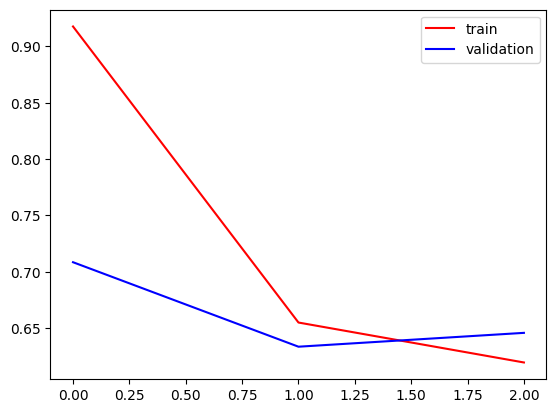

In [10]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 2020 images belonging to 2 classes.


In [15]:
#predict the test data
predictions = resnet_model.predict(test_data)
print(predictions)

64/64 [==============================] - 6s 91ms/step
[[0.8280139 ]
 [0.5750665 ]
 [0.4063562 ]
 ...
 [0.91745263]
 [0.57610816]
 [0.78885216]]


In [16]:
len(predictions)

2020

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have ground truth labels (true_labels) and predicted labels (predictions)
true_labels = test_data.classes
predicted_labels = (predictions > 0.5).astype(int)  # Adjust the threshold as needed

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Confusion Matrix:
[[155 865]
 [132 868]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.15      0.24      1020
           1       0.50      0.87      0.64      1000

    accuracy                           0.51      2020
   macro avg       0.52      0.51      0.44      2020
weighted avg       0.52      0.51      0.43      2020

